In [1]:
import os
import sys
import time
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.backend as K
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.regularizers import l1_l2
from sklearn.metrics import accuracy_score
from collections import OrderedDict, Counter
from tensorflow.python.ops import gen_array_ops
from keras.layers import Dense, Dropout, Flatten
from names import Names as n

In [2]:
from scipy.stats import gaussian_kde
from descartes import PolygonPatch
import alphashape
from sklearn.cluster import KMeans

In [3]:
from pathlib import Path
from harness.test_harness_class import TestHarness
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.weighted_logistic import weighted_logistic_classifier

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)
matplotlib.use("tkagg")
warnings.filterwarnings('ignore')

In [5]:
%load_ext autoreload
%autoreload 2
from notebook_functions import *
%matplotlib inline

In [6]:
col_idx = OrderedDict([(n.label, 0), ("inducer_concentration", 1), ("timepoint", 2), ("percent_live", 3)])

# Read in Data and Prepare Variables

In [7]:
duke_v2 = pd.read_csv("experiment_data/processed/duke_v2.csv")

In [8]:
duke_v2

,inducer_concentration,timepoint,stain,FSC-A,SSC-A,YL1-A,FSC-H,SSC-H,YL1-H,FSC-W,SSC-W,YL1-W,percent_live,source
0,0.0,0.0,1.0,6.02060,6.02060,4.90093,5.76444,5.41198,2.94052,3.00988,3.00988,0.00000,78.633333,duke_v2
1,0.0,0.0,1.0,5.38945,4.59275,2.59770,5.37109,4.59422,2.41497,1.96379,1.87506,0.00000,78.633333,duke_v2
2,0.0,0.0,1.0,5.45014,4.88310,2.40312,5.41537,4.84833,2.23300,1.94448,1.89763,0.00000,78.633333,duke_v2
3,0.0,0.0,1.0,5.64436,5.11836,2.86629,5.58375,5.06345,2.63849,1.95424,1.94448,0.00000,78.633333,duke_v2
4,0.0,0.0,1.0,5.25856,4.68307,1.80618,5.25983,4.68142,2.18184,1.90309,1.86332,0.00000,78.633333,duke_v2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1613456,80.0,6.0,0.0,5.01983,5.63438,2.68124,5.02845,5.61526,2.58320,1.83885,1.91908,0.00000,0.000000,duke_v2
1613457,80.0,6.0,0.0,4.78530,5.35882,3.03941,4.77970,5.33517,3.08207,1.83251,1.88649,1.04139,0.000000,duke_v2
1613458,80.0,6.0,0.0,4.99094,5.07843,3.13577,4.91230,5.03511,3.12418,1.88649,1.89209,1.17609,0.000000,duke_v2
1613459,80.0,6.0,0.0,4.56064,5.69383,2.90309,4.55811,5.69243,2.91169,1.77815,1.83251,0.00000,0.000000,duke_v2


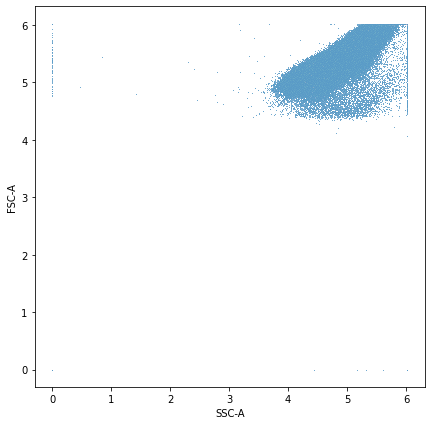

In [9]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=duke_v2.loc[duke_v2["stain"]==1], x="SSC-A", y="FSC-A", s=1)

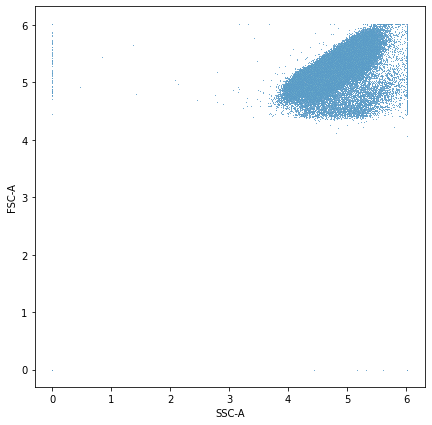

In [10]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=duke_v2.loc[duke_v2[n.inducer_concentration] == 80.0],
                x="SSC-A", y="FSC-A", s=1)

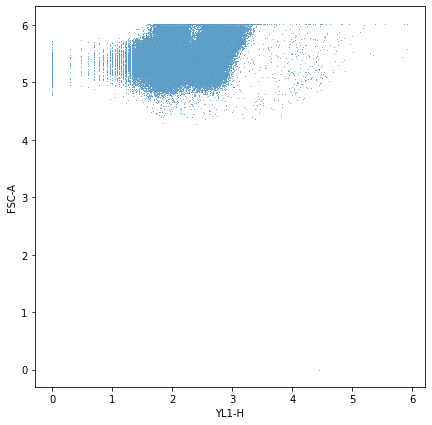

In [17]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=duke_v2.loc[duke_v2[n.inducer_concentration] == 0.0],
                x="YL1-H", y="FSC-A", s=1)

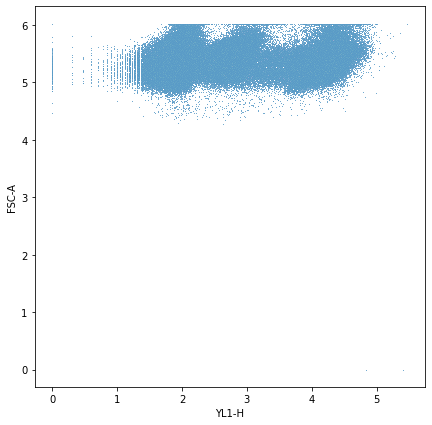

In [18]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=duke_v2.loc[duke_v2[n.inducer_concentration] == 20.0],
                x="YL1-H", y="FSC-A", s=1)

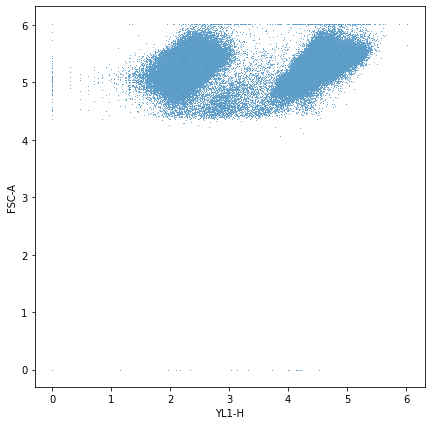

In [15]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=duke_v2.loc[duke_v2[n.inducer_concentration] == 80.0],
                x="YL1-H", y="FSC-A", s=1)

In [19]:
duke_stained = duke_v2.loc[duke_v2["stain"] == 1]
duke_unstained = duke_v2.loc[duke_v2["stain"] == 0]

In [20]:
features_unstained = n.morph_cols
features_stained_duke = n.morph_cols + ["YL1-A", "YL1-H", "YL1-W"]

In [21]:
print(features_unstained)
print(features_stained_duke)

['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W']
['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'YL1-A', 'YL1-H', 'YL1-W']


# Generate RF Labels for Stained data but only using Morph Features

In [22]:
df_duke_stained_morph, \
X_duke_stained_morph, \
Y_duke_stained_morph = generate_rf_labels_from_conditions(duke_stained,
                                                          features_unstained,
                                                live_conditions=[{'inducer_concentration': 0.0, 'timepoint': 0.0},
                                                                 {'inducer_concentration': 0.0, 'timepoint': 0.5},
                                                                 {'inducer_concentration': 0.0, 'timepoint': 3.0},
                                                                 {'inducer_concentration': 0.0, 'timepoint': 6.0}],
                                                dead_conditions=None
                                                         )

Conditions designated as Live: [{'inducer_concentration': 0.0, 'timepoint': 0.0}, {'inducer_concentration': 0.0, 'timepoint': 0.5}, {'inducer_concentration': 0.0, 'timepoint': 3.0}, {'inducer_concentration': 0.0, 'timepoint': 6.0}]
Conditions designated as Dead: [{'inducer_concentration': 20.0, 'timepoint': 6.0}, {'inducer_concentration': 80.0, 'timepoint': 6.0}]


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:35:55
Starting Classification training...
Training time was: 85.31 seconds
Testing time was: 10.36 seconds
Prediction time of untested data was: 62.80936789512634
Run finished at 14:38:41. Total run time = 165.85 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




# All Plots/Models use Stained data, but models only use morph features

**Replacing CFU percent_live values for 0% ethanol at time 0.5 and 1.0 with 100% before feeding into the model**

In [23]:
Y_duke_stained_morph.loc[(Y_duke_stained_morph[n.inducer_concentration] == 0.0) & 
                             (Y_duke_stained_morph[n.timepoint].isin([0.5, 1.0, 5.0])), n.percent_live] = 100.0
# Y_duke_stained_morph


Model Boosting took 436.62716007232666 seconds
Training Accuracy = 78.91%
Counter({1: 418666, 0: 383817})
Instructions for updating:
Please use `model.predict()` instead.


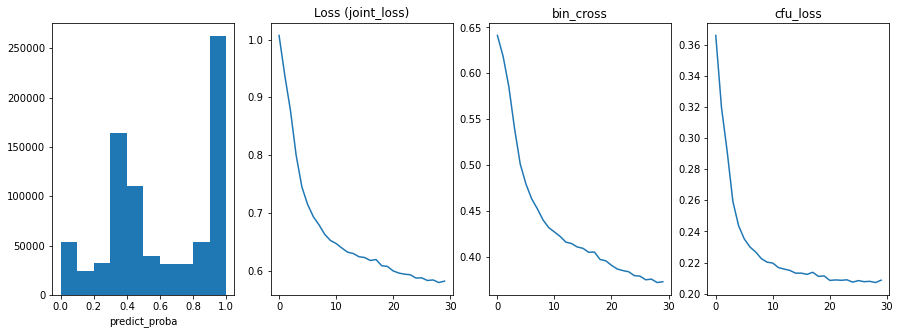

In [24]:
cr_duke_stained_morph, \
pl_duke_stained_morph = run_model(model_function=booster_model_v2, lr=0.001,
                                      loss = joint_loss_wrapper(1), metrics = [bin_cross, cfu_loss],
                                      X = X_duke_stained_morph, Y = Y_duke_stained_morph, 
                                      epochs = 30, batch_size = 2048,
                                      verbose = False, shuffle = True, plot_type="line")

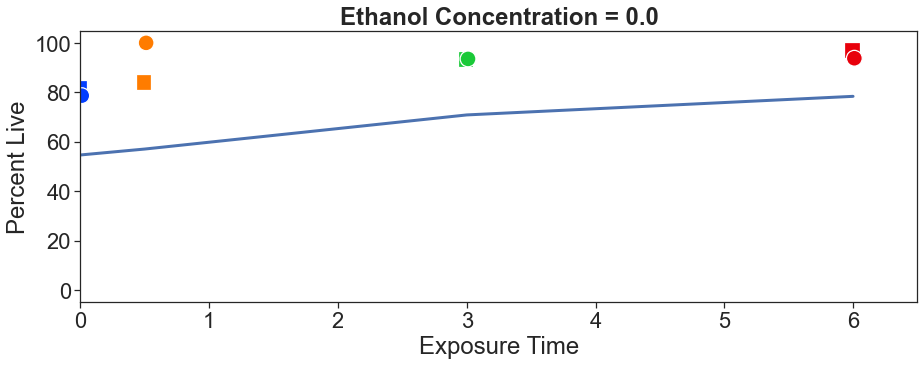

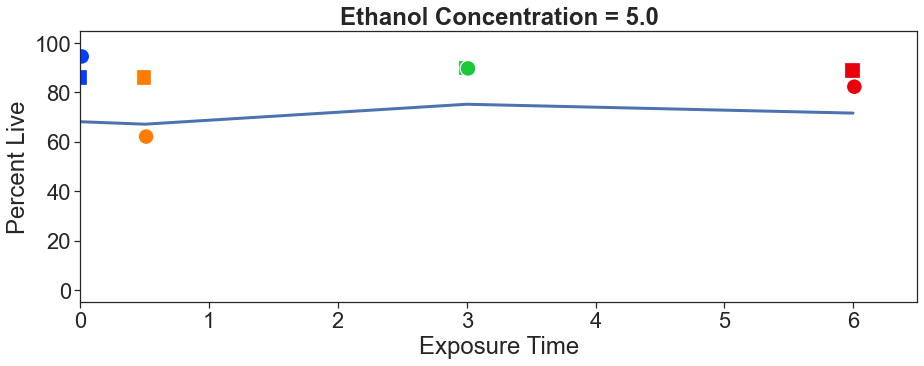

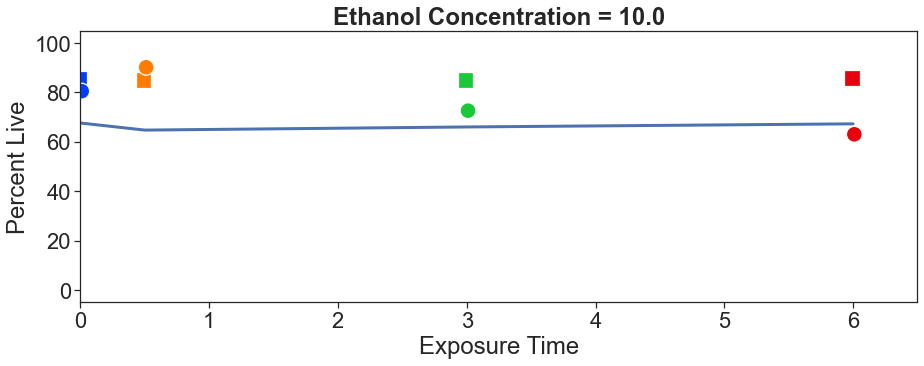

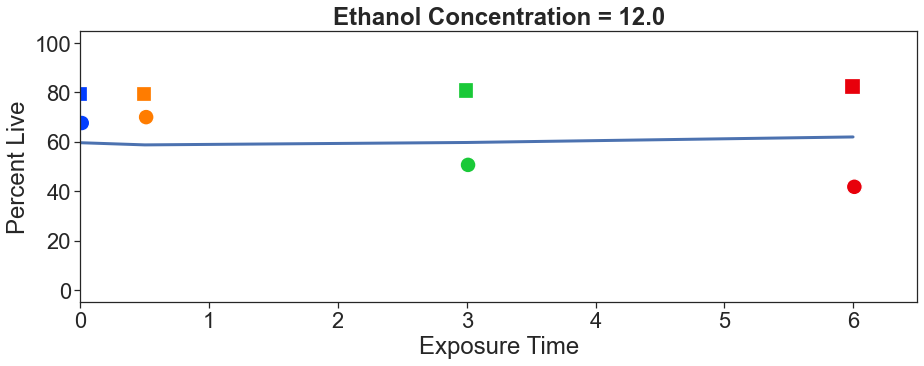

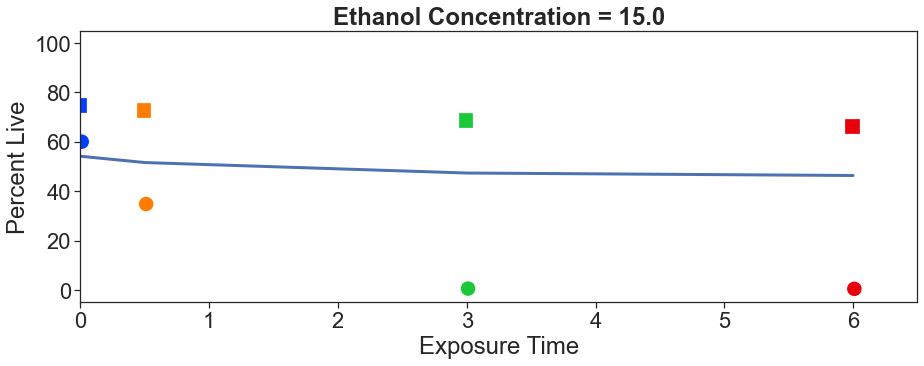

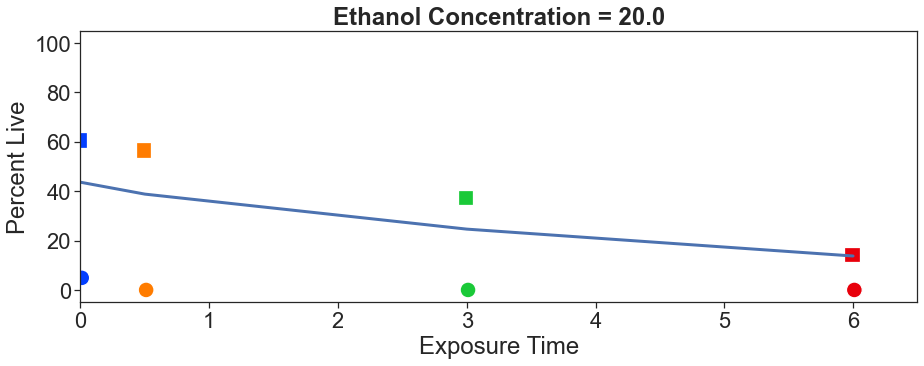

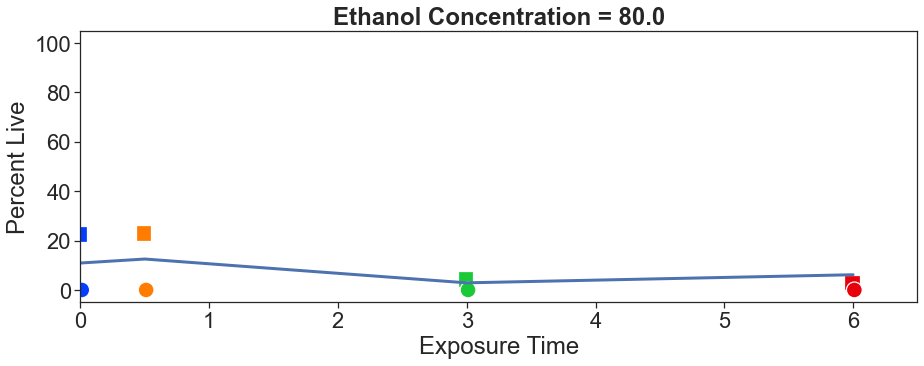

In [25]:
plot_per_cond(cr_duke_stained_morph)

In [26]:
info_duke_stained_morph = get_all_run_info(df_duke_stained_morph, 
                                               X_duke_stained_morph,
                                               pl_duke_stained_morph,
                                               append_df_cols=["YL1-A", "YL1-H", "YL1-W"])

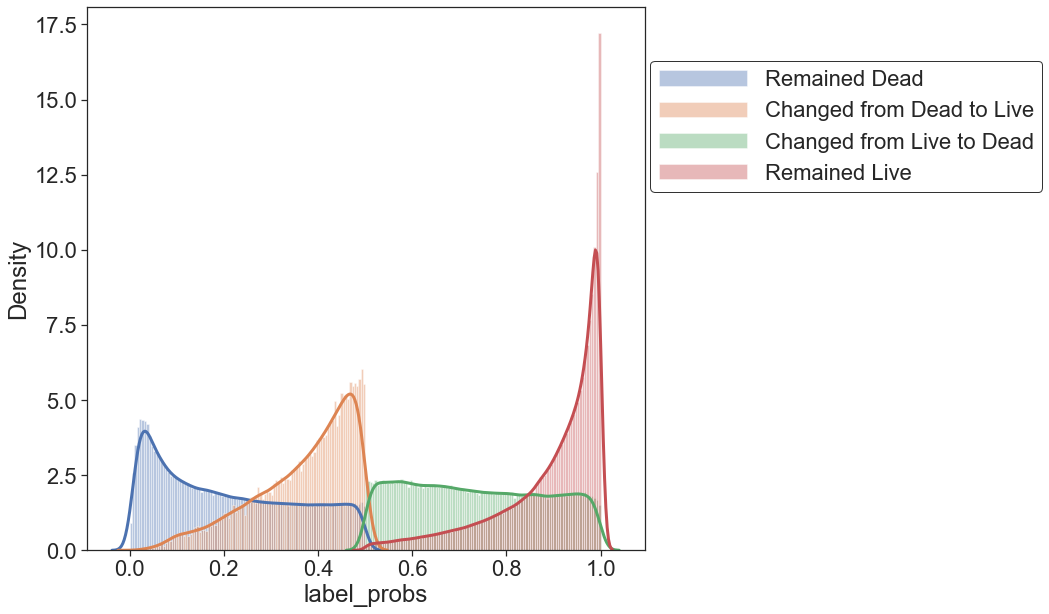

In [27]:
plot_prob_changes(info_duke_stained_morph, None)

In [28]:
info_duke_stained_morph

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,YL1-A,YL1-H,YL1-W,label,inducer_concentration,timepoint,cfu_percent_live,nn_preds,changed,change_type,nn_percent_live,label_probs
0,6.02060,5.76444,3.00988,6.02060,5.41198,3.00988,4.90093,2.94052,0.00000,1.0,0.0,0.0,78.633333,1.0,False,Remained Live,54.626667,0.915136
1,5.38945,5.37109,1.96379,4.59275,4.59422,1.87506,2.59770,2.41497,0.00000,1.0,0.0,0.0,78.633333,0.0,True,Changed from Live to Dead,54.626667,0.995113
2,5.45014,5.41537,1.94448,4.88310,4.84833,1.89763,2.40312,2.23300,0.00000,1.0,0.0,0.0,78.633333,1.0,False,Remained Live,54.626667,0.918747
3,5.64436,5.58375,1.95424,5.11836,5.06345,1.94448,2.86629,2.63849,0.00000,1.0,0.0,0.0,78.633333,1.0,False,Remained Live,54.626667,0.986546
4,5.25856,5.25983,1.90309,4.68307,4.68142,1.86332,1.80618,2.18184,0.00000,1.0,0.0,0.0,78.633333,0.0,True,Changed from Live to Dead,54.626667,0.927789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802478,5.40536,5.35042,1.93450,4.99815,4.95624,1.93450,5.04934,5.00503,1.96379,0.0,80.0,6.0,0.000000,0.0,False,Remained Dead,6.155182,0.033214
802479,5.45617,5.32792,1.97313,5.24021,5.15502,1.95904,5.20301,5.10656,1.97313,0.0,80.0,6.0,0.000000,0.0,False,Remained Dead,6.155182,0.038716
802480,5.23300,5.22052,1.88649,4.56023,4.56326,1.85733,4.79102,4.77915,1.92428,0.0,80.0,6.0,0.000000,0.0,False,Remained Dead,6.155182,0.313298
802481,5.53827,5.36166,2.01284,5.02246,4.87132,1.96848,4.97019,4.82215,1.98677,0.0,80.0,6.0,0.000000,0.0,False,Remained Dead,6.155182,0.066690


# Calculate KDEs to get point density

In [29]:
conc_df_all = get_conc_df_with_kde_values(run_info=info_duke_stained_morph,
                                          conc="all",
                                          features=features_stained_duke,
                                          cc="YL1-H")

# Scatter + KDE Plots

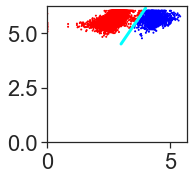

Percent of AutoGater live predictions that are left of the SOA dashed line: 92.69


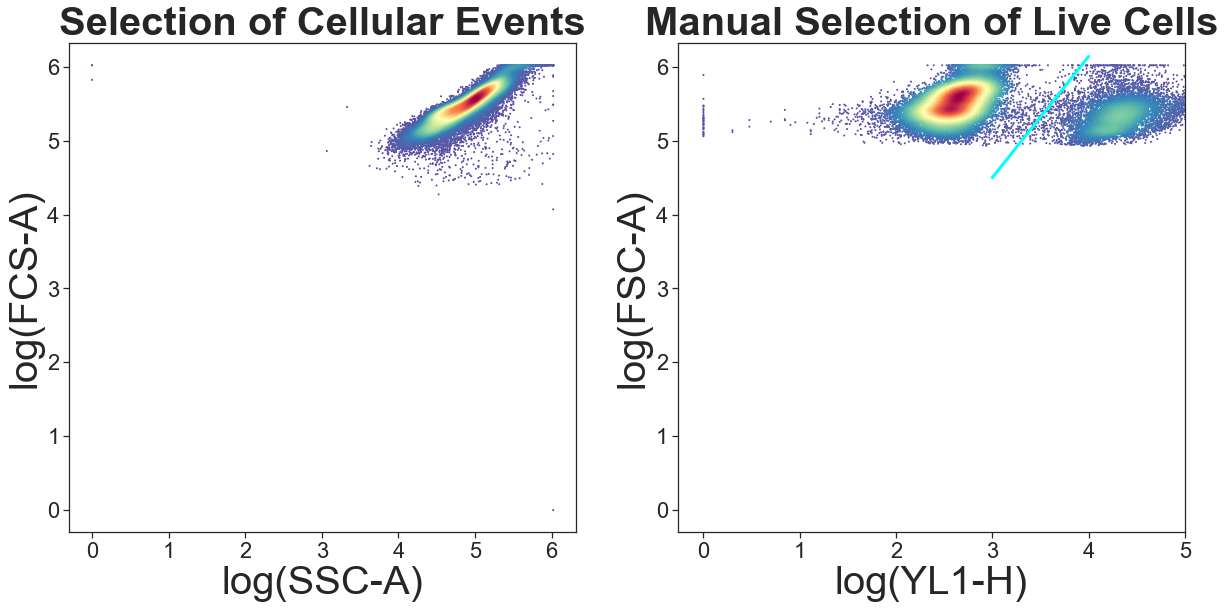

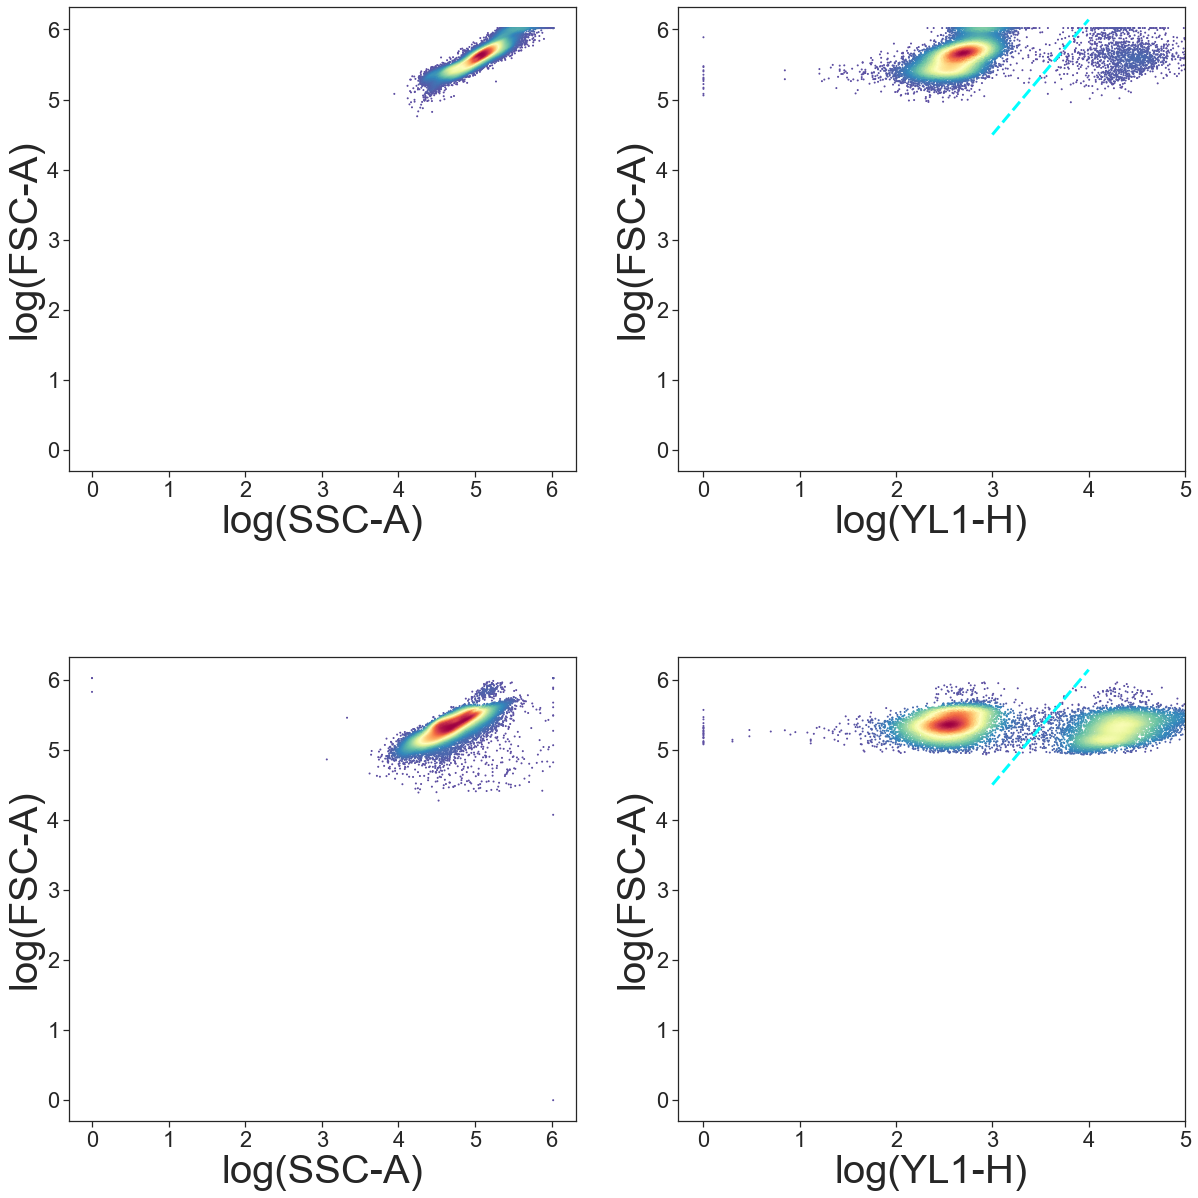

In [30]:
%matplotlib inline
kde_df = kde_scatter(conc_df_all, cc="YL1-H", logged=True, 
                     fraction_of_points_based_on_kde=0.95, 
                     point_1_that_defines_line=(3, 4.5),
                     point_2_that_defines_line=(4, 6.14),
                     cmap="Spectral_r", pred_col="nn_preds")

## Summary Table and Plot

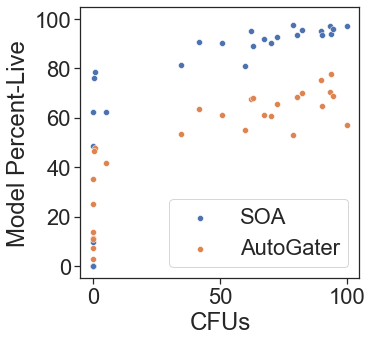

R-Squared between CFUs and State-of-the-Art predicted Percent-Live: 0.04
R-Squared between CFUs and AutoGater predicted Percent-Live: -0.03
R-Squared between CFUs and RFC predicted Percent-Live: -0.11



In [31]:
%matplotlib inline
summary_table = summary_table_of_results(kde_df)

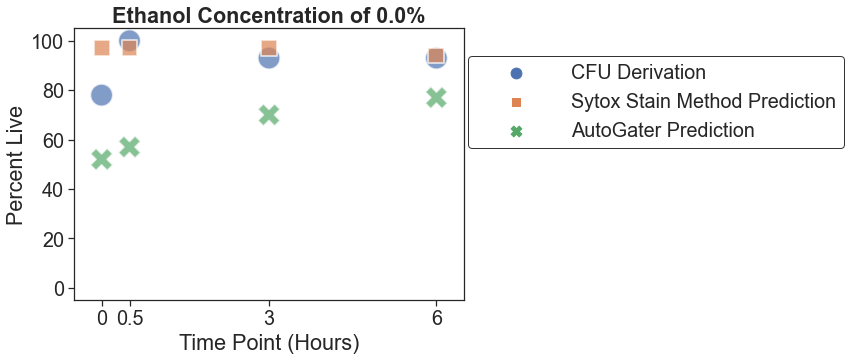

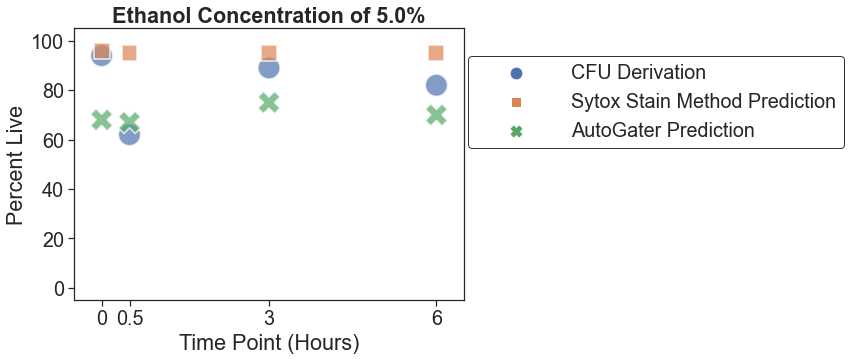

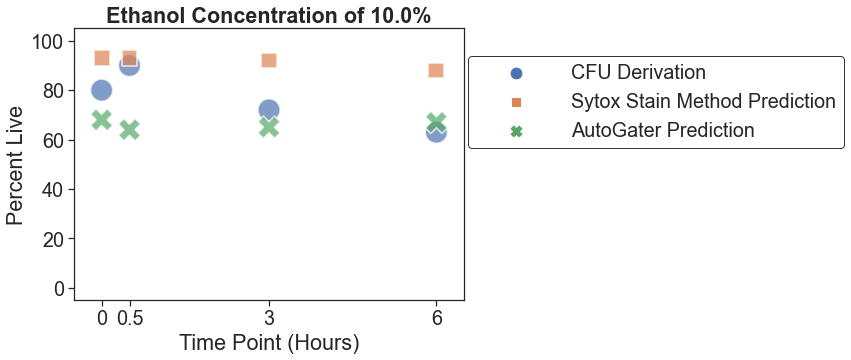

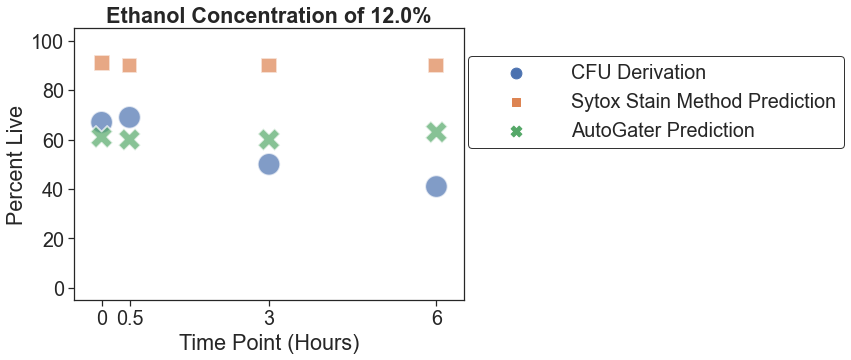

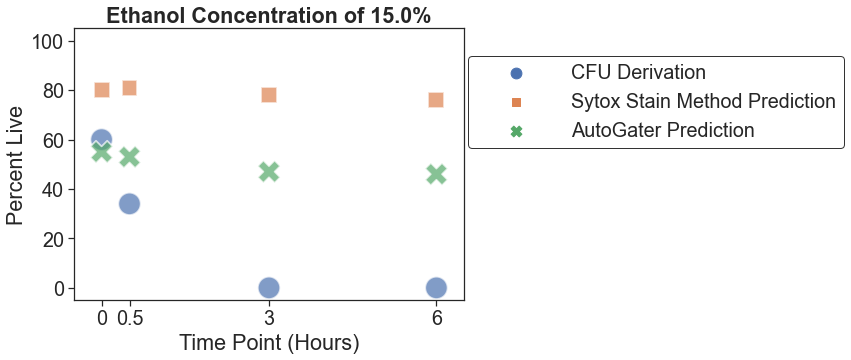

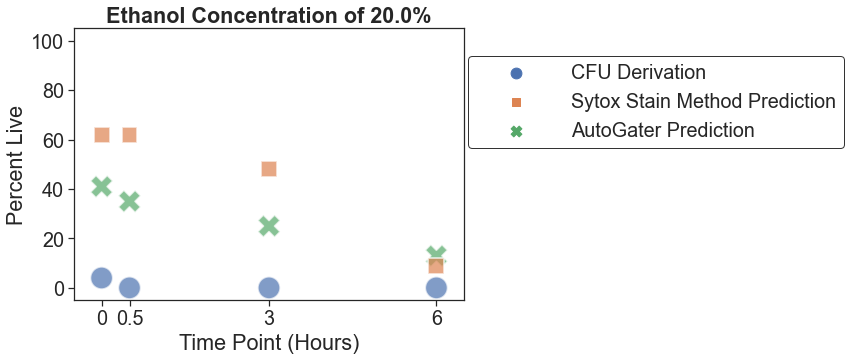

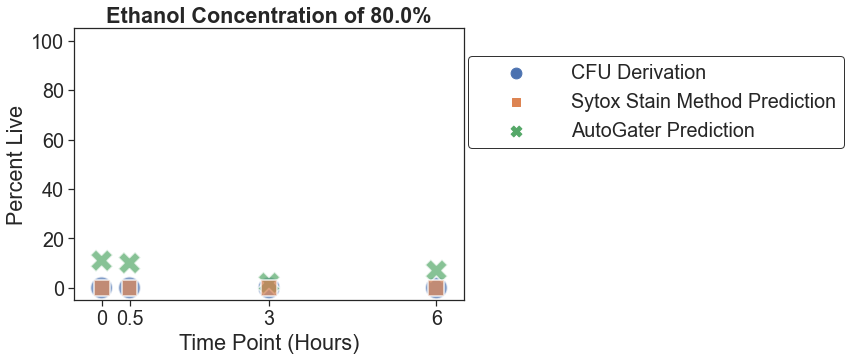

In [32]:
%matplotlib inline
percent_live_comparison_plot(summary_table)